In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy.stats import boxcox, skew, kurtosis, yeojohnson
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.tsa.api as smt
import time
import sqlite3

In [57]:
def plot_predictions(test,predicted, title):
    plt.figure(figsize=(15,6));
    sns.set_context('poster',font_scale=1)
    plt.plot(test, "-", label='Real Ransomware Attacks');
    plt.plot(predicted, ".", label='Predicted Ransomware Attacks');
    plt.title('Ransomware Attack Prediction', fontsize=40);
    plt.xlabel('');
    plt.ylabel('');
    plt.xticks(rotation=45);
    plt.legend();
    plt.tight_layout();
    plt.savefig(f'{title}.png');
    plt.show();
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
def tmplot(y, title, lags=None, figsize=(12,8)):
    plt.style.use('fivethirtyeight');
    sns.set_context('poster',font_scale=1)
    fig = plt.figure(figsize=figsize);
    layout = (2, 2);
    ts_ax = plt.subplot2grid(layout, (0,0));
    hist_ax = plt.subplot2grid(layout, (0,1));
    acf_ax = plt.subplot2grid(layout, (1,0));
    pacf_ax = plt.subplot2grid(layout, (1,1));
    y.plot(ax=ts_ax);
    ts_ax.set_title(title);
    y.plot(ax=hist_ax, kind='hist', bins=5);
    hist_ax.set_title('Histogram');
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax);
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax);
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]];
    sns.despine();
    plt.tight_layout();
    plt.savefig('AC_PAC.png');
    return (ts_ax, acf_ax, pacf_ax)
def plot_loss(history, label, n):
    plt.tight_layout()
    plt.figure(figsize=(12, 8))
    plt.semilogy(history.epoch, history.history['loss'], color='blue',
                 label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color='orange',
                 label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [3]:
conn = sqlite3.connect('BTC_Data.db')

In [4]:
%%time
#Ransomware transactions by year

ransomware_df = pd.read_sql_query("""SELECT * 
                                    FROM BTC_Transactions 
                                    WHERE ROWID IN (SELECT ROWID FROM BTC_Transactions ORDER BY RANDOM() 
                                    LIMIT 1000000);""", conn)

Wall time: 1min 45s


In [5]:
ransomware_df

,address,year,day,length,weight,count,looped,neighbors,income,label
0,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,2.441406e-04,1,0,1,1.000000e+08,princetonLocky
1,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000e+00,1,0,2,2.000000e+08,princetonCerber
2,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,7.284841e-02,456,0,1,2.000000e+08,princetonLocky
3,112nEBUadWiMxzUUASNZpQ9AvePtrJVuca,2016,247,0,1.000000e+00,1,0,2,1.085600e+08,princetonCerber
4,112Ns49UobQn1cX1G1axs1cmGvjFBxVxvf,2016,146,144,8.774848e-01,4817,0,1,1.040200e+08,montrealCryptXXX
...,...,...,...,...,...,...,...,...,...,...
999995,199dvTdD99LMjBxb3KjzyMDMtNRaiReiVR,2012,242,144,1.031449e-40,126,0,2,5.069000e+08,white
999996,1HJjfxQTMUz1kGjrPN72Ykay31pU2ed9yT,2012,242,144,1.358148e-16,1535,0,2,3.996544e+07,white
999997,15FEHoVkPx9XsjrDeBLbvGWUoDceLTcDHV,2012,242,2,5.000000e-01,1,0,1,5.470325e+09,white
999998,1LgRRJKhs5NhC9gA7qvtsnmtYopzGNbhQP,2012,242,6,2.500000e-01,4,0,1,1.475690e+09,white


In [6]:
ransomware_df.dtypes

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object

In [7]:
%%time
#Format the Data
ransomware_df['month_day'] = pd.to_datetime(ransomware_df['day'], format='%j').dt.strftime('%m-%d')
ransomware_df['date'] = pd.to_datetime(ransomware_df['month_day'].astype(str)+'-'+ransomware_df['year'].astype(str))
ransomware_df['income'] = ransomware_df['income'].map('{:.2f}'.format).astype(float)
ransomware_df['weight'] = ransomware_df['weight'].map('{:.2f}'.format).astype(float)
ransomware_df.loc[ransomware_df['label'] == 'white', 'class'] = '0'
ransomware_df.loc[ransomware_df['label'] != 'white', 'class'] = '1'
ransomware_df['class'] = ransomware_df['class'].astype(int)
ransomware_df.drop(columns=['month_day','year','day', 'label'], inplace=True)

Wall time: 20.6 s


In [8]:
ransomware_df

,address,length,weight,count,looped,neighbors,income,date,class
0,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,44,0.00,1,0,1,1.000000e+08,2016-05-12,1
1,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,0,1.00,1,0,2,2.000000e+08,2016-09-03,1
2,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,144,0.07,456,0,1,2.000000e+08,2016-08-26,1
3,112nEBUadWiMxzUUASNZpQ9AvePtrJVuca,0,1.00,1,0,2,1.085600e+08,2016-09-04,1
4,112Ns49UobQn1cX1G1axs1cmGvjFBxVxvf,144,0.88,4817,0,1,1.040200e+08,2016-05-26,1
...,...,...,...,...,...,...,...,...,...
999995,199dvTdD99LMjBxb3KjzyMDMtNRaiReiVR,144,0.00,126,0,2,5.069000e+08,2012-08-30,0
999996,1HJjfxQTMUz1kGjrPN72Ykay31pU2ed9yT,144,0.00,1535,0,2,3.996544e+07,2012-08-30,0
999997,15FEHoVkPx9XsjrDeBLbvGWUoDceLTcDHV,2,0.50,1,0,1,5.470325e+09,2012-08-30,0
999998,1LgRRJKhs5NhC9gA7qvtsnmtYopzGNbhQP,6,0.25,4,0,1,1.475690e+09,2012-08-30,0


In [9]:
pos_ransomware_df = ransomware_df.loc[ransomware_df['class'] == 1]
pos_ransomware_df

,address,length,weight,count,looped,neighbors,income,date,class
0,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,44,0.00,1,0,1,100000000.0,2016-05-12,1
1,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,0,1.00,1,0,2,200000000.0,2016-09-03,1
2,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,144,0.07,456,0,1,200000000.0,2016-08-26,1
3,112nEBUadWiMxzUUASNZpQ9AvePtrJVuca,0,1.00,1,0,2,108560000.0,2016-09-04,1
4,112Ns49UobQn1cX1G1axs1cmGvjFBxVxvf,144,0.88,4817,0,1,104020000.0,2016-05-26,1
...,...,...,...,...,...,...,...,...,...
831811,1Zzq1TordGW9WjqRtSvjB6cFZ8xVi4Z8v,0,1.00,1,0,4,240000000.0,2016-06-04,1
831812,1Zzq1TordGW9WjqRtSvjB6cFZ8xVi4Z8v,32,0.00,1,0,2,120000000.0,2016-06-09,1
831813,35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw,144,1.20,2725,0,3,188000000.0,2016-12-11,1
831814,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,0,0.50,1,0,2,57142857.0,2016-10-04,1


In [10]:
yearly_df = pos_ransomware_df.groupby('date').agg([sum]).reset_index()
yearly_df.drop(columns=['address'], inplace=True)
yearly_df.columns = yearly_df.columns.droplevel(-1)

C:\Users\Steph\anaconda3\envs\myenv\lib\site-packages\pandas\core\generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [11]:
yearly_df

,date,length,weight,count,looped,neighbors,income,class
0,2011-09-25,54,0.00,43,0,2,119000000.0,1
1,2011-09-29,0,1.00,1,0,2,100000000.0,1
2,2011-10-01,140,0.00,94,0,4,184000000.0,2
3,2011-10-04,12,0.06,38,0,2,135000000.0,1
4,2011-10-10,114,0.00,41,0,2,117000000.0,1
...,...,...,...,...,...,...,...,...
1769,2017-08-29,144,0.99,5949,0,2,40000000.0,1
1770,2017-08-30,70,0.00,2,0,2,40000000.0,1
1771,2017-08-31,0,3.00,3,0,6,112000000.0,3
1772,2017-09-19,26,0.12,1,0,1,199324000.0,1


Wall time: 257 ms


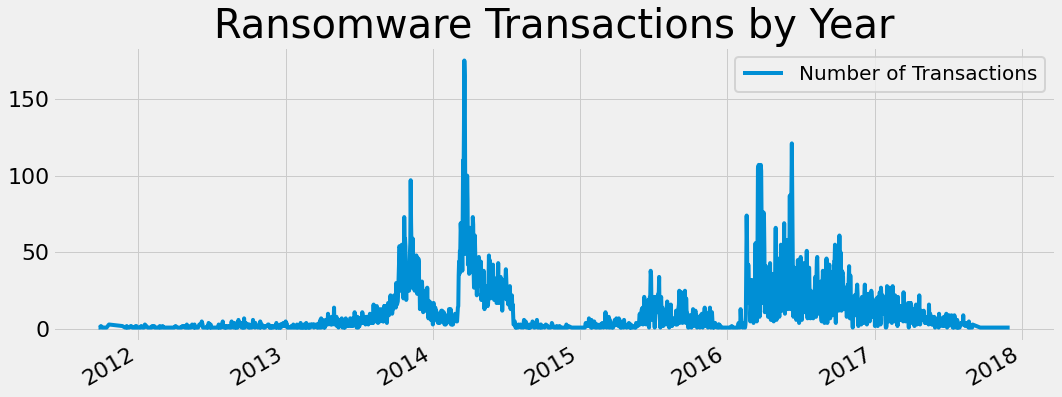

In [23]:
%%time
#Plot the data
yearly_df.plot(x='date', y='class',figsize=(16,6));
sns.set_context('poster',font_scale=1);
plt.legend(['Number of Transactions'], fontsize=20);
plt.title('Ransomware Transactions by Year', fontsize=40);
plt.xlabel("")
plt.savefig('Ransom_Transactions.png');

Wall time: 957 ms


(<AxesSubplot:title={'center':'BTC Ransomware Transactions'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

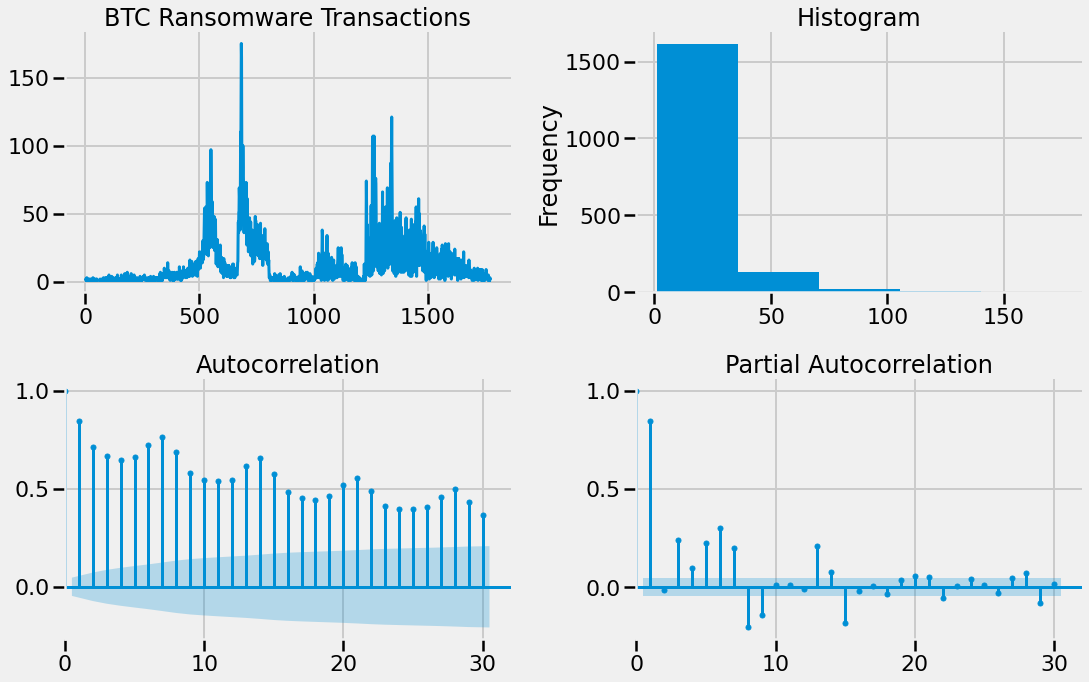

In [58]:
%%time
tmplot(yearly_df['class'],'BTC Ransomware Transactions',lags=30, figsize=(16,10))

In [14]:
yearly_df

,date,length,weight,count,looped,neighbors,income,class
0,2011-09-25,54,0.00,43,0,2,119000000.0,1
1,2011-09-29,0,1.00,1,0,2,100000000.0,1
2,2011-10-01,140,0.00,94,0,4,184000000.0,2
3,2011-10-04,12,0.06,38,0,2,135000000.0,1
4,2011-10-10,114,0.00,41,0,2,117000000.0,1
...,...,...,...,...,...,...,...,...
1769,2017-08-29,144,0.99,5949,0,2,40000000.0,1
1770,2017-08-30,70,0.00,2,0,2,40000000.0,1
1771,2017-08-31,0,3.00,3,0,6,112000000.0,3
1772,2017-09-19,26,0.12,1,0,1,199324000.0,1


In [15]:
%%time
# Scaling the training set
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(yearly_df[['length','weight', 'count','looped','neighbors','income','class']])

Wall time: 8.01 ms


In [16]:
#Split and process the data
def train_test(dataset, split=.8):
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, test
def process(dataset, samples):
    dataX = []
    dataY = []
    for i in range(len(dataset)-samples-1):
        dataX.append(dataset[i:(i+samples)])
        dataY.append(dataset[i+samples])
    return np.array(dataX), (np.array(dataY).reshape(np.array(dataY).shape[0],-1))
#Unscale
def unscale(dataset):
    copy = np.repeat(dataset, X_train_scaled.shape[1], axis=-1)
    return copy

In [17]:
%%time
#Format data
samples = 7
train, test = train_test(X_train_scaled, .95)
X_train, y_train = process(train, samples)
X_test, y_test = process(test, samples)

Wall time: 9.11 ms


In [18]:
%%time
#Check shapes
print(X_train_scaled.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1774, 7)
(1677, 7, 7)
(1677, 7)
(81, 7, 7)
(81, 7)
Wall time: 999 µs


In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, LSTM, GRU
import math
from keras import optimizers
from keras import initializers
from keras.callbacks import EarlyStopping

METRICS = [
      keras.metrics.MeanSquaredError(name="MSE"), 
      keras.metrics.RootMeanSquaredError(name="RMSE"), 
      keras.metrics.MeanAbsoluteError(name="MAE"),
      keras.metrics.MeanAbsolutePercentageError(name="MAPE"), 
      keras.metrics.MeanSquaredLogarithmicError(name="MSLE"),
]

def make_model(df, metrics=None):
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=(df.shape[1],df.shape[2])))
    regressor.add(Dropout(0.2))
    # Second LSTM layer
    regressor.add(LSTM(units=75, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Fourth LSTM layer
    regressor.add(LSTM(units=1))
    regressor.add(Dropout(0.2))
    # The output layer
    regressor.add(Dense(units=1))
    # Compiling the RNN
    regressor.compile(optimizer='adam',
                  loss='mean_absolute_error',
                 metrics=metrics)
    return regressor

In [20]:
%%time
model_1 = make_model(X_train, metrics=METRICS)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            43200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 75)             52800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 75)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 50)             25200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 2

In [21]:
%%time
batch_size = 32
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='MAE', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

results = model_1.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)

Wall time: 28 s


In [22]:
%%time
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_1.save_weights(initial_weights)

Wall time: 88.1 ms


In [24]:
%%time
#Fit the model
base_model = make_model(X_train, metrics=METRICS)
base_model.load_weights(initial_weights)
base_history = base_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_split=.1, 
    verbose=0)

Wall time: 2min 53s


<Figure size 432x288 with 0 Axes>

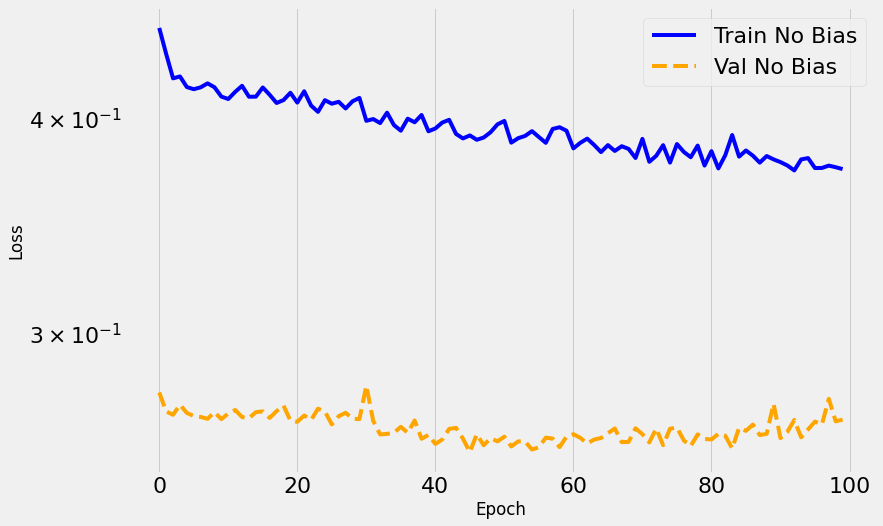

In [36]:
plot_loss(base_history, 'No Bias', 0)

In [26]:
%%time
#Predictions
train_predict = base_model.predict(X_train)
test_predict = base_model.predict(X_test)

Wall time: 3.81 s


In [27]:
%%time
train_predict = scalar.inverse_transform(unscale(train_predict))[:,-1]
test_predict = scalar.inverse_transform(unscale(test_predict))[:,-1]
y_train_unscaled = scalar.inverse_transform(y_train)[:,-1]
y_test_unscaled = scalar.inverse_transform(y_test)[:,-1]

Wall time: 0 ns


In [28]:
%%time
test = np.concatenate((y_train_unscaled, y_test_unscaled), axis=0)
pred = np.concatenate((train_predict, test_predict), axis=0)

Wall time: 0 ns


In [29]:
result_df = pd.DataFrame(index=yearly_df.date[-len(test):])
result_df['test'] = test.tolist()
result_df['pred'] = pred.tolist()
result_df

,test,pred
date,,
2011-12-10,3.0,5.115930
2011-12-14,2.0,5.147551
2011-12-15,1.0,5.137149
2011-12-18,1.0,5.115394
2011-12-19,1.0,5.135728
...,...,...
2017-08-29,1.0,5.658993
2017-08-30,1.0,5.449416
2017-08-31,1.0,5.227133


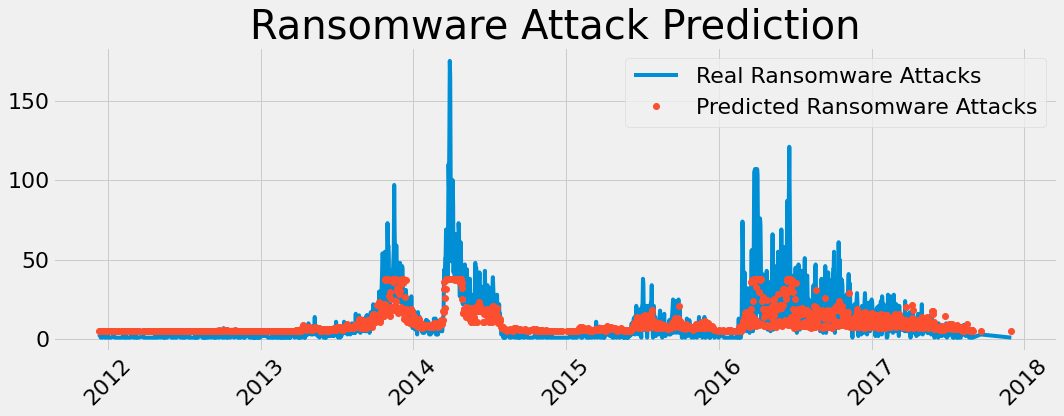

In [56]:
plot_predictions(result_df.test, result_df.pred, 'prediction')

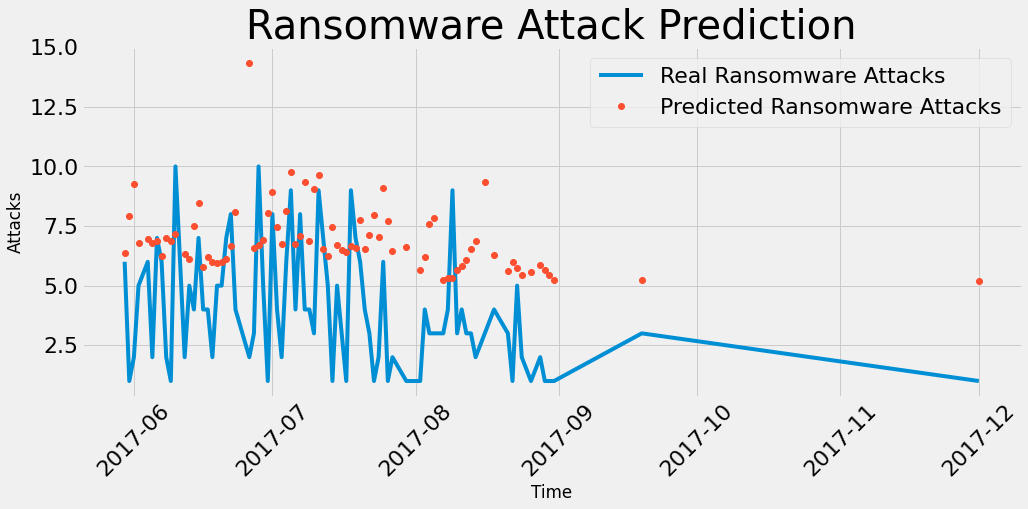

<Figure size 432x288 with 0 Axes>

In [45]:
plot_predictions(result_df.test[-y_test.shape[0]:], result_df.pred[-y_test.shape[0]:],'Prediction_Zoom.png')

In [43]:
#Baseline Test Run 
nn_table_test = PrettyTable()
nn_table_test.field_names = ['Model Name','Mean Squared Error','Root Mean Squared Error','Mean Absolute Error','Mean Absolute % Error', 'Mean Squared Log Error']

nn_pred_test = base_model.predict(X_test, batch_size=batch_size)

nn_table_test.add_row([
    'Baseline Neural Net',
    '{:.3f}'.format(base_history.history['MSE'][-1]),
    '{:.3f}'.format(base_history.history['RMSE'][-1]),
    '{:.3f}'.format(base_history.history['MAE'][-1]),
    '{:.3f}'.format(base_history.history['MAPE'][-1]),
    '{:.3f}'.format(base_history.history['MSLE'][-1])
])

print(nn_table_test)

+---------------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+
|      Model Name     | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | Mean Absolute % Error | Mean Squared Log Error |
+---------------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+
| Baseline Neural Net |       0.769        |          0.877          |        0.384        |        238.237        |         0.087          |
+---------------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+
